In [111]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score
from sklearn.feature_selection import mutual_info_regression

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

import pytz
import shap
import pickle

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

RANDOM_STATE = 42

# Perameters


In [112]:
node_id = '10004098'
dir_out = '../figures/spatial/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1))#.astype(str)
#for i in range(len(wavelengths)):
#    wavelengths[i] = wavelengths[i] + 'nm'
#wavelengths = list(wavelengths)

# Read Data

In [212]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + 'driving_' + node_id + '_NEXRAD_2km.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')

# iwant = df.index.date < datetime.date(2020, 3, 1)
# df = df[iwant]


In [213]:
# grid parameters
step = 100 # grid resolution (meter) in x-y plane

z_0, delta_z = 0, 10000
num_z = int(delta_z // 1000) + 1

delta_y , delta_x  = 1000, 1000 # neighbor distance
delta_iy, delta_ix = int(delta_y / step), int(delta_x / step)

# neighbor parameters
neighbor = {
    ''    : (        0,         0),
    # 1km
    'N1'  : ( delta_iy,         0),
    'N1E1': ( delta_iy,  delta_ix),
    'E1'  : (        0,  delta_ix),
    'S1E1': (-delta_iy,  delta_ix),
    'S1'  : (-delta_iy,         0),
    'S1W1': (-delta_iy, -delta_ix),
    'W1'  : (        0, -delta_ix),
    'N1W1': ( delta_iy, -delta_ix),
    # 2km
    'N2'  : ( 2*delta_iy,           0),
    'N2E2': ( 2*delta_iy,  2*delta_ix),
    'E2'  : (          0,  2*delta_ix),
    'S2E2': (-2*delta_iy,  2*delta_ix),
    'S2'  : (-2*delta_iy,           0),
    'S2W2': (-2*delta_iy, -2*delta_ix),
    'W2'  : (          0, -2*delta_ix),
    'N2W2': ( 2*delta_iy, -2*delta_ix)
}

In [214]:
features0 = ['altitude', 'Zenith', 'Azimuth', 'Sun Distance']

features = features0.copy()
reflectivities = []
for iz in range(num_z):
    for direction in neighbor:
        var = 'reflectivity_' + str(iz) + 'km'
        if direction:
            var += '_' + direction
        reflectivities.append(var)

features += reflectivities
features = np.array(features)

num_features = len(features)
print(num_features)

# targets =np.array([str(wavelength) + 'nm' for wavelength in wavelengths]) # skip Illuminance, keep Wavelengths
targets = ['Illuminance']


191


In [215]:
# try to apply exp on the reflectivities
# since L_Z=10 log10(Z/Z_0) in dbz
# so (Z/Z_0) = 10^(L_z/10)
df[reflectivities] = (10**(df[reflectivities]/10)).fillna(0)

In [218]:
X = df[features]
Y = df[targets] # model and scaler use multi output

In [219]:
def showCorr(cols):
    size = len(cols)*0.8
    fig = plt.figure(figsize=(size, size))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df[cols].corr(), cmap='RdBu')
    cax.set_clim(-1, 1);
    #plt.title('Correlation Matrix\n\n\n')
    fig.colorbar(cax)
    ax.set_xticklabels(np.append([""],cols), rotation=45, ha="left")
    ax.set_yticklabels(np.append([""],cols))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [220]:
showCorr(np.append(features, targets[0]))

In [221]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


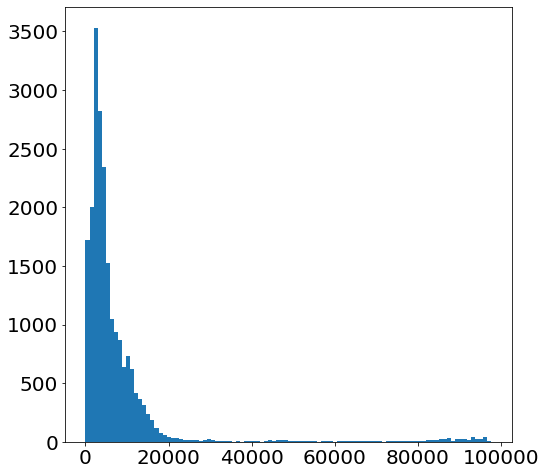

In [235]:
plt.hist(df['Illuminance'], bins = 100);
# plt.xlim(12,24)

(12.0, 24.0)

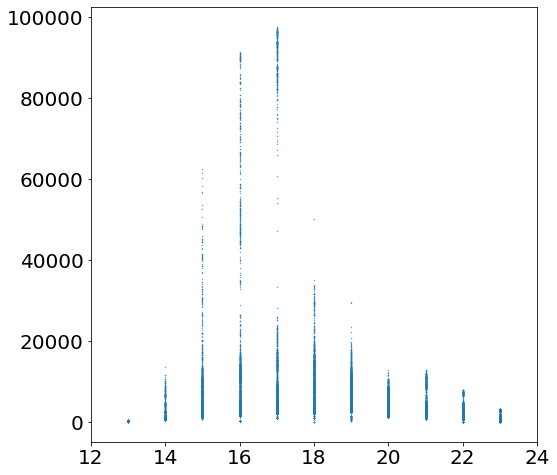

In [229]:
plt.scatter(df.index.hour, df['Illuminance'], s = 0.1)
plt.xlim(12,24)

In [152]:
# try PCA on the NEXRAD reflectivities data
pca1 = PCA(n_components=len(reflectivities), random_state = RANDOM_STATE)
X_temp = pca1.fit_transform(X_train.loc[:,reflectivities])
print(np.cumsum(pca1.explained_variance_)/np.sum(pca1.explained_variance_))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [108]:
# PCA on the NEXRAD reflectivities data
n_components = 97 # 53 # 17 # num_features
reflectivities_DR = ['PC ' + str(i) for i in range(n_components)]
features_DR = np.append(features0, reflectivities_DR)

DR = 'PCA'
Cluster = 'None'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)


X_train_DR = X_train[features0].copy()
X_train_DR[reflectivities_DR] = pca.fit_transform(X_train.loc[:,reflectivities])

X_test_DR = X_test[features0].copy()
X_test_DR[reflectivities_DR] = pca.transform(X_test.loc[:,reflectivities])

# print(pca.explained_variance_)

# save pca model
dir_DR = '../models/spatial/'
if not os.path.exists(dir_DR):
    os.mkdir(dir_DR)

fn_DR = dir_DR + DR + '.sav'
pickle.dump(pca, open(fn_DR, 'wb'))

In [ ]:
# scaler_x = StandardScaler()
# X_train_scaled = scaler_x.fit_transform(X_train)
# X_test_scaled = scaler_x.transform(X_test)

# scaler_y = StandardScaler()
# Y_train_scaled = scaler_y.fit_transform(Y_train)
# Y_test_scaled = scaler_y.transform(Y_test)


In [12]:
# # scale the data again before NN
# scaler_x2 = StandardScaler()
# X_train_scaled_DR_scaled = scaler_x2.fit_transform(X_train_scaled_DR)
# X_test_scaled_DR_scaled = scaler_x2.transform(X_test_scaled_DR)

# Model Trainning

In [31]:
import lightgbm as lgb
import warnings
from sklearn.model_selection import RandomizedSearchCV


In [239]:
# RandomizedSearchCV
rs_params = {
#     'boosting_type': ['gbdt'], # default = 'gbdt'
    'num_leaves': range(2, 160), # default = 31, Maximum tree leaves for base learners
    'max_depth' : [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9], # default = -1, Maximum tree depth for base learners
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4], # default = 0.1
    'n_estimators': range(10, 200, 10), # default = 100, Number of boosted trees
#     'subsample_for_bin': [200000], # default = 200000
    'objective' : ['regression'], # ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier
#     'class_weight': ['balanced'], # default = None, for multi-class
#     'is_unbalance': [True], # default = False, for binary
#     'min_split_gain' : [0.], # default=0.
#     'min_child_weight' : [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], # default=1e-3
#     'min_child_samples': range(1, 500), # default=20
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # default=1.
#     'subsample_freq': [0], # default=0
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # default=1.
    'reg_alpha': [0, 1e-1, 0.5, 1, 2, 5, 7, 10, 50, 100], # default=0.  L1 regularization
    'reg_lambda': [0, 1e-1, 0.5, 1, 5, 10, 20, 50, 100], # default=0.  L2 regularization
    'random_state' : [RANDOM_STATE], # default=None
#     'n_jobs': [-1], # default=-1
    'silent': [True], # default=True
#     'importance_type': ['split'], # default='split', or 'gain'
}

start_time = time.time()
# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv = RandomizedSearchCV(estimator = lgb.LGBMRegressor(random_state = RANDOM_STATE), 
                           param_distributions = rs_params,
#                            scoring= '', # 'f1' is better than 'roc_auc' for imbalanced data
                           refit = True,
                           verbose = True,
                           cv = 2,
                           n_jobs = -1,
                           n_iter = 1000,
                          )
fit_params = {"early_stopping_rounds":30, 
              "eval_metric" : 'mse', #
              "eval_set" : [(X_test, Y_test.values[:,0])],
              'eval_names': ['valid'],
              'verbose': 100,
              'categorical_feature': 'auto'
             }

# Train on training data
warnings.filterwarnings("ignore")
# rs_cv.fit(X_train_scaled_DR_scaled, Y_train_scaled, **fit_params)
rs_cv.fit(X_train, Y_train.values[:,0], **fit_params)

print(rs_cv.best_params_)
print(rs_cv.best_score_)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 2 folds for each of 1000 candidates, totalling 2000 fits
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid's l2: 3.70789e+06
{'subsample': 0.9, 'silent': True, 'reg_lambda': 5, 'reg_alpha': 1, 'random_state': 42, 'objective': 'regression', 'num_leaves': 134, 'n_estimators': 170, 'max_depth': -1, 'learning_rate': 0.4, 'colsample_bytree': 1.0}
0.972066837627611
--- 1012.1829881668091 seconds ---
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[90]	valid's l2: 1.21121e+08
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[70]	valid's l2: 1.95529e+07
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[60]	valid's l2: 8.12913e+06
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[30]	valid's l2

Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 1.21272e+07
Did not meet early stopping. Best iteration is:
[130]	valid's l2: 9.74294e+06
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[30]	valid's l2: 3.47305e+07
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[10]	valid's l2: 6.97027e+06
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[60]	valid's l2: 1.82989e+07
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid's l2: 5.14145e+06
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[20]	valid's l2: 1.35008e+08
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[10]	valid's l2: 5.2655e+07
Training until va

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[60]	valid's l2: 2.76643e+07
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[60]	valid's l2: 9.94985e+06
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[40]	valid's l2: 7.79631e+06
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.37779e+07
Did not meet early stopping. Best iteration is:
[180]	valid's l2: 1.99544e+07
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 5.1088e+06
Did not meet early stopping. Best iteration is:
[170]	valid's l2: 5.02125e+06
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[10]	valid's l2: 5.28036e+07
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[8

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[90]	valid's l2: 1.21923e+08
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[70]	valid's l2: 1.71788e+07
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[60]	valid's l2: 8.03734e+06
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[30]	valid's l2: 1.32972e+07
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.2836e+07
Did not meet early stopping. Best iteration is:
[180]	valid's l2: 1.91754e+07
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 6.28458e+06
Did not meet early stopping. Best iteration is:
[130]	valid's l2: 6.23211e+06
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[7

In [158]:
rs_cv.best_params_

{'subsample': 0.5,
 'silent': True,
 'reg_lambda': 10,
 'reg_alpha': 2,
 'random_state': 42,
 'objective': 'regression',
 'num_leaves': 125,
 'n_estimators': 140,
 'max_depth': -1,
 'learning_rate': 0.3,
 'colsample_bytree': 1.0}

In [163]:
# Fit the Model with Optimized Hyper-Parameters
# param = {
#     'num_leaves': 128, # default = 31, Maximum tree leaves for base learners
#     'max_depth' : -1, # default = -1, Maximum tree depth for base learners
#     'learning_rate': 0.05, # default = 0.1
#     'n_estimators': 140, # default = 100, Number of boosted trees
# #     'subsample_for_bin': 200000, # default = 200000
#     'objective' : 'regression', # ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier
# #     'class_weight': 'balanced', # default = None, for multi-class
# #     'min_child_weight' : 100., # default=1e-3
# #     'min_child_samples': 467, # default=20
#     'subsample': 1.0, # default=1.
#     'colsample_bytree': 0.9, # default=1.
#     'reg_alpha': 50, # default=0.  L1 regularization
#     'reg_lambda': 0, # default=0.  L2 regularization
#     'random_state' : RANDOM_STATE, # default=None
#     'silent': True, # default=True
# }

param = {
    'subsample': 0.5,
    'silent': True,
    'reg_lambda': 10,
    'reg_alpha': 2,
    'random_state': 42,
    'objective': 'regression',
    'num_leaves': 125,
    'n_estimators': 140,
    'max_depth': -1,
    'learning_rate': 0.3,
    'colsample_bytree': 1.0
}

structure   = '_' + DR + str(n_components) \
            + '_' + 'ne' + str(param['n_estimators'])\
            + '_' + 'de' + str(param['max_depth'])\
            + '_' + 'nl' + str(param['num_leaves'])\
            + '_' + 'sr' + str(param['subsample'])\
            + '_' + 'fr' + str(param['colsample_bytree'])\
            + '_' + 'l1_' + str(param['reg_alpha'])\
            + '_' + 'l2_' + str(param['reg_lambda'])\


model = lgb.LGBMRegressor(**param)
fit_params = {"early_stopping_rounds": 100, 
              "eval_metric": 'l2', # l2 is mean_squared_error
              "eval_set": [(X_test, Y_test)],
              'eval_names': ['valid'],
              'verbose': 100,
              'categorical_feature': 'auto', # default='auto'
             }

warnings.filterwarnings("ignore")
# model.fit(X_train_scaled_DR_scaled, Y_train_scaled)#, **fit_params)
model.fit(X_train, Y_train)#, **fit_params)

LGBMRegressor(learning_rate=0.3, n_estimators=140, num_leaves=125,
              objective='regression', random_state=42, reg_alpha=2,
              reg_lambda=10, subsample=0.5)

In [176]:
from sklearn.linear_model import LinearRegression

In [184]:
reg = LinearRegression()
reg.fit(X_train.fillna(-99), Y_train)


LinearRegression()

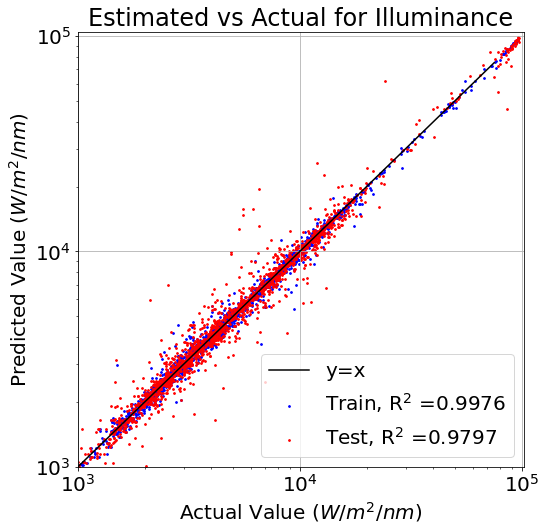

In [187]:
from sklearn.metrics import r2_score

# Y_train_pred = scaler_y.inverse_transform(
#                     model.predict( X_train_scaled_DR_scaled )
#                     ) # for train
Y_train_pred = model.predict( X_train)#_DR[reflectivities_DR] )

# Y_train_pred = regr.predict( X_train_scaled_DR_scaled ) # for train
train_score = r2_score(Y_train, Y_train_pred)

# Y_test_pred = scaler_y.inverse_transform(
#                     model.predict( X_test_scaled_DR_scaled )
#                     )# for test
Y_test_pred = model.predict( X_test)#_DR[reflectivities_DR] )

# Y_test_pred = regr.predict( X_test_scaled_DR_scaled )# for test
test_score = r2_score(Y_test, Y_test_pred)

# flatten
Y_train_flatten = Y_train.values.flatten()
Y_train_pred_flatten = Y_train_pred.flatten()

Y_test_flatten = Y_test.values.flatten()
Y_test_pred_flatten = Y_test_pred.flatten()

Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)

y_line = np.linspace(Y_min,Y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten), 2000, replace = False)
plt.scatter(Y_train_flatten[id_train], Y_train_pred_flatten[id_train], s=3, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])

id_test = np.random.choice(len(Y_test_flatten), 2000, replace = False)
plt.scatter(Y_test_flatten[id_test], Y_test_pred_flatten[id_test], s=3, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])

plt.xlim(10E2, )
plt.ylim(10E2, )

ax.set_title('Estimated vs Actual for Illuminance')# Spectrum')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Predicted Value $(W/m^2/nm)$')
plt.xscale('log')
plt.yscale('log')
plt.legend( loc='lower right')
plt.grid()
# plt.tight_layout()

if not os.path.exists(dir_out + 'Illuminance'):
    os.mkdir(dir_out + 'Illuminance')
# plt.savefig(dir_out + 'Illuminance' +'/MLP_performance_whole'+structure+'.png')



In [173]:
# Create object that can calculate shap values
num_shap = 2000
explainer = shap.TreeExplainer(model)
# Calculate shap_values
tree_shap_values = explainer.shap_values(X_train.iloc[:num_shap]) # 421 x num_shap x n_components


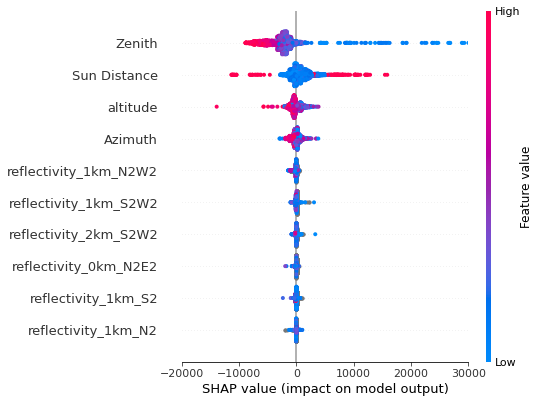

In [174]:
# plot
max_display = 10
# shap_values = pca.inverse_transform(shap_values_DR)
shap.summary_plot(tree_shap_values, X_train[:num_shap].values,
                  feature_names = features,#features_DR,
                  plot_size=(8,int(max_display/1.5)),#'auto'
                  max_display = max_display,
                  show=False
                 )
plt.xlim(-20000, 30000)
plt.tight_layout()
# plt.savefig(dir_out + 'Illuminance' + '/MLP_shapPCA_'+ 'Illuminance' +structure+'.png')

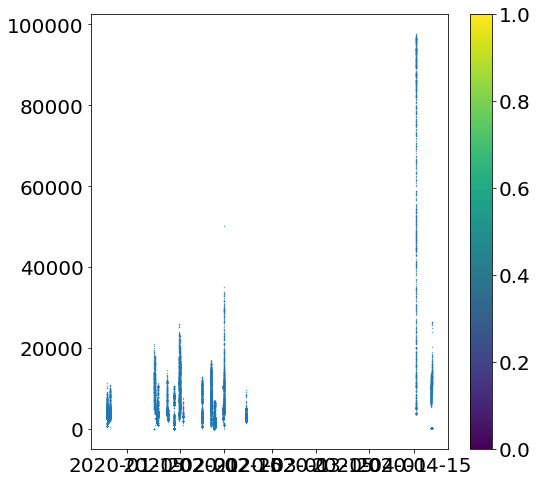

In [202]:
plt.scatter(df.index, df['Illuminance'], s = 0.1)
plt.colorbar()

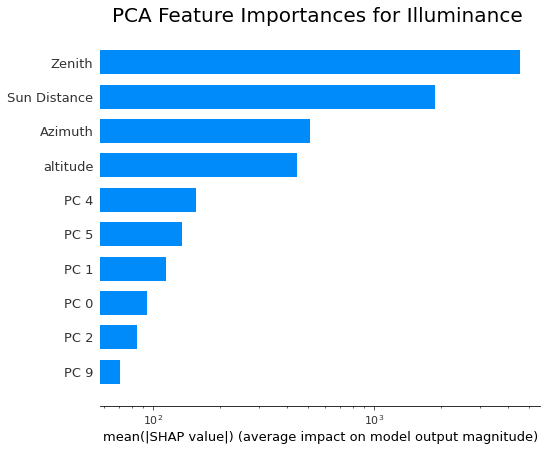

In [43]:
importances_DR = np.mean(np.abs(tree_shap_values_DR), axis = 0)
indices = np.argsort(importances_DR)

# color positive/negative impact blue/red
# colormap = {1:'red',-1:'blue', 0:'grey'}
# impacts = np.array([])
# corrcoef = np.array([])
# sign = np.array([])
# for i in range(n_components):
#     impact_i = (shap_values_DR[:,i]*np.sign(X_train_scaled_DR_scaled[:num_shap,i] - X_train_scaled_DR_scaled[:num_shap, i].mean() )).mean()
#     impacts = np.append(impacts, impact_i)
    
#     corrcoef_i = np.corrcoef(X_train_scaled_DR_scaled[:,i], Y_train_pred.mean(axis = 1))[0,1]
#     corrcoef = np.append(corrcoef, corrcoef_i)
    
#     sign_i = np.sign(corrcoef_i)
#     sign = np.append(sign, sign_i)

# sign = sign[indices]
# impacts = impacts[indices]
# corrcoef = corrcoef[indices]

# # norm = mpl.colors.SymLogNorm(10, vmin=0, vmax=+0.05)
# norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
# cmap = cm.get_cmap('RdBu_r')
# m = cm.ScalarMappable(norm=norm, cmap=cmap)

# color = [colormap[val] for val in sign]
# # color = [m.to_rgba(val) for val in impacts]
# # color = [m.to_rgba(val) for val in corrcoef]

shap.summary_plot(tree_shap_values_DR, X_train_DR[:num_shap],
                  feature_names = features_DR,
                  plot_size=(8,max_display/1.5),#'auto'
#                   color = color,
                  max_display = max_display,
                  show = False,
                  plot_type = 'bar'
                 )

plt.xscale("log")
plt.title(DR + ' Feature Importances for Illuminance ', fontsize = 20)
plt.tight_layout()
plt.savefig(dir_out + 'Illuminance' + '/MLP_'+DR+'Importances_' + 'Illuminance' + structure +'.png')
